This tutorial and the assets can be downloaded as part of the [Wallaroo Tutorials repository](https://github.com/WallarooLabs/Wallaroo_Tutorials/blob/wallaroo2024.4_tutorials/wallaroo-model-operations-tutorials/deploy/by-framework/BYOP/wallaroo-model-upload-deploy-byop-cv-tutorial).

## Custom Model Computer Vision Upload, Auto Packaging, and Deploy Tutorial

The following tutorial demonstrates using Wallaroo deploying Bring Your Own Predict aka Custom Model in a Wallaroo instance.  The model is auto packaged upon uploading.  Once ready, the model is deployed and sample inferences performed on it.

## Introduction

This tutorial focuses on the Resnet50 computer vision model. By default, this provides the following outputs from receiving an image converted to tensor values:

* `boxes`: The bounding boxes for detected objects.
* `classes`: The class of the detected object (bottle, coat, person, etc).
* `confidences`: The confidence the model has that the detected model is the class.

For this demonstration, the model is modified with [Wallaroo Bring Your Own Predict (BYOP)](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-model-uploads/wallaroo-sdk-model-arbitrary-python/) to add two additional fields:

* `avg_px_intensity`: the average pixel intensity checks the input to determine the average value of the Red/Green/Blue pixel values.  This is used as a benchmark to determine if the two images are significantly different.  For example, an all white photo would have an `avg_px_intensity` of `1`, while an all blank photo would have a value of `0`.
* `avg_confidence`: The average confidence of all detected objects.

## Prerequisites

* A Wallaroo Ops instance 2024.1 and above

To download the Wallaroo Computer Vision model for this tutorial, use the following link:

https://storage.googleapis.com/wallaroo-public-data/cv-demo-models/model-with-pixel-intensity.zip

Add the folder to the directory `models`.

The following libraries are required to run the tutorial:

```python
onnx==1.12.0
onnxruntime==1.12.1
torchvision
torch
matplotlib==3.5.0
opencv-python
imutils
pytz
ipywidgets
```

To run this tutorial outside of a Wallaroo Ops center, the [Wallaroo SDK](https://pypi.org/project/wallaroo/) is available and is installed via `pip` with:

`pip install wallaroo==2024.4.4`


## Steps

### Import Libraries

The following libraries are used to execute this tutorial.  The `utils.py` provides additional helper methods for rendering the images into tensor fields and other useful tasks.

In [1]:
# preload needed libraries 

import wallaroo
from wallaroo.object import EntityNotFoundError
from wallaroo.framework import Framework
from IPython.display import display
from IPython.display import Image
import pandas as pd
import json
import datetime
import time
import cv2
import matplotlib.pyplot as plt
import string
import random
import pyarrow as pa
import sys
import asyncio
import numpy as np


import utils
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

import datetime

# api based inference request
import requests

import utils

# ignoring warnings for demonstration
import warnings
warnings.filterwarnings('ignore')

### Connect to the Wallaroo Instance

The first step is to connect to Wallaroo through the Wallaroo client.  The Python library is included in the Wallaroo install and available through the Jupyter Hub interface provided with your Wallaroo environment.

This is accomplished using the `wallaroo.Client()` command, which provides a URL to grant the SDK permission to your specific Wallaroo environment.  When displayed, enter the URL into a browser and confirm permissions.  Store the connection into a variable that can be referenced later.

If logging into the Wallaroo instance through the internal JupyterHub service, use `wl = wallaroo.Client()`.  For more information on Wallaroo Client settings, see the [Client Connection guide](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-client/).

The option `request_timeout` provides additional time for the Wallaroo model upload process to complete.

In [2]:
wl = wallaroo.Client(request_timeout=600)

### Create Workspace

We will create a workspace to manage our pipeline and models.  The following variables will set the name of our sample workspace then set it as the current workspace.

Workspace names must be unique.  The following helper function will either create a new workspace, or retrieve an existing one with the same name.  Verify that a pre-existing workspace has been shared with the targeted user.

Set the variables `workspace_name` to ensure a unique workspace name if required.

The workspace will then be set as the Current Workspace.  Model uploads and pipeline creation through the SDK are set in the current workspace.

* References
  * [Wallaroo SDK Essentials Guide: Workspace Management](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-workspace/)

In [3]:
workspace_name = "cv-retail-edge-observability"
model_name = "resnet-with-intensity"
model_file_name = "./models/model-with-pixel-intensity.zip"
pipeline_name = "retail-inv-tracker-edge-obs"

workspace = wl.get_workspace(name=workspace_name, create_if_not_exist=True)
wl.set_current_workspace(workspace)

{'name': 'cv-retail-edge-observability', 'id': 25, 'archived': False, 'created_by': '65124b18-8382-49af-b3c8-ada3b9df3330', 'created_at': '2024-04-16T20:50:32.628602+00:00', 'models': [], 'pipelines': []}

### Upload Model

The model is uploaded as a BYOP (Bring Your Own Predict) aka Aribitrary model, where the model, Python script and other artifacts are included in a .zip file.  This requires the input and output schemas for the model specified in Apache Arrow Schema format.

* References
  * [Wallaroo SDK Essentials Guide: Model Uploads and Registrations: Custom Model](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-model-uploads/wallaroo-sdk-model-arbitrary-python/)
  
The contents of the Wallaroo BYOP script includes the following to load the model, and add additional fields.  By default the `frcnn-resnet` model outputs the following fields:

* **boxes**:  A List of the the bounding boxes of each detected object.
* **classes**:  A List of the class of each detected object.
* **confidences**:  A confidence score of how likely the object is what class was detected.

The `model-with-pixel-intensity.zip` BYOP model uses that class, then adds in the following fields.

* **avg_px_intensity**:  The average pixel intensidy of the image.  This provides a way of determining if the same pictures from the same camera has significant changes.  For example, a security camera would have a different pixel intensity in one picture where the light was on, versus one one when the lights were off.
* **avg_confidence**:  An average of all of the **confidences** output by the model. This is used for observability and track model drift.

The following `predict` method is used in the BYOP model.  

```python
def _predict(self, input_data: InferenceData):
        # Parse inputs
        inputs = input_data["tensor"]

        # Pass to onnx model
        # `dynamic_axes` hasn't been set in torch.onnx.export()
        # that is used in CVDemoUtils.loadPytorchAndConvertToOnnx()
        # therefore we cannot do batch inference
        ort_sess = ort.InferenceSession(self._model.SerializeToString())
        outputs = ort_sess.run(None, {"data": inputs.astype(np.float32)})

        boxes, classes, confidences = outputs

        # Calculate input derivatives
        avg_px_intensity = np.mean(inputs[0])
        
        # Calculate output derivatives
        avg_confidence = np.mean(confidences)

        # batch size isn't specified in the onnx session output
        # but we need to return a batch of outputs
        return {
            "boxes": np.array([boxes]),
            "classes": np.array([classes]),
            "confidences": np.array([confidences]),
            "avg_px_intensity": np.array([[avg_px_intensity]]),
            "avg_confidence": np.array([[avg_confidence]]),
        }
```

For full details on Wallaroo BYOP models, see [Wallaroo SDK Essentials Guide: Model Uploads and Registrations: Custom Model](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-model-uploads/wallaroo-sdk-model-arbitrary-python/).

The following sets the input/output schemas in Apache `pyarrow` format, and uploads the models. Once uploaded, it is automatically 

In [4]:
input_schema = pa.schema([
    pa.field('tensor', pa.list_(
        pa.list_(
            pa.list_(
                pa.float32(), # images are normalized
                list_size=640
            ),
            list_size=480
        ),
        list_size=3
    )),
])

output_schema = pa.schema([
    pa.field('boxes', pa.list_(pa.list_(pa.float32(), list_size=4))),
    pa.field('classes', pa.list_(pa.int64())),
    pa.field('confidences', pa.list_(pa.float32())),
    pa.field('avg_px_intensity', pa.list_(pa.float32())),
    pa.field('avg_confidence', pa.list_(pa.float32())),
])


model = wl.upload_model(model_name, 
                        model_file_name, 
                        framework=Framework.CUSTOM,
                        input_schema=input_schema, 
                        output_schema=output_schema)

Waiting for model loading - this will take up to 10.0min.
Model is pending loading to a container runtime..
Model is attempting loading to a container runtime.............successful

Ready


### Deploy Pipeline

Next we configure the hardware we want to use for deployment. If we plan on eventually deploying to edge, this is a good way to simulate edge hardware conditions.  The BYOP model is deployed as a Wallaroo Containerized Runtime, so the hardware allocation is performed through the `sidekick` options.

* References
  * [Wallaroo SDK Essentials Guide: Pipeline Deployment Configuration](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-pipelines/wallaroo-sdk-essentials-pipeline-deployment-config/)

In [5]:
deployment_config = wallaroo.DeploymentConfigBuilder() \
    .replica_count(1) \
    .cpus(1) \
    .memory("2Gi") \
    .sidekick_cpus(model, 1) \
    .sidekick_memory(model, '6Gi') \
    .build()

We create the pipeline with the `wallaroo.client.build_pipeline` method, and assign our model as a model pipeline step.  Once complete, we will deploy the pipeline to allocate resources from the Kuberntes cluster hosting the Wallaroo Ops to the pipeline.

In [6]:
pipeline = wl.build_pipeline(pipeline_name)
pipeline.clear()
pipeline.add_model_step(model)
pipeline.deploy(deployment_config = deployment_config)

name,retail-inv-tracker-edge-obs
created,2024-04-16 20:52:25.348600+00:00
last_updated,2024-04-16 20:52:25.694362+00:00
deployed,True
arch,x86
accel,none
tags,
versions,"677630ba-68a0-4c32-958c-58084e24d9f9, 4fa28f09-0bc7-4622-9cbd-1706a3c94285"
steps,resnet-with-intensity
published,False


## Sample Inferences

We'll perform some sample inferences and display the outputs.  For each image, we'll use the inference result to draw the bounding boxes for all objects with a confidence value higher than 50%.  We'll display the average confidence across all detected objects after the bounding box image.

For more details on performing inferences, see [Wallaroo SDK Essentials Guide: Inference Management](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-inferences/).

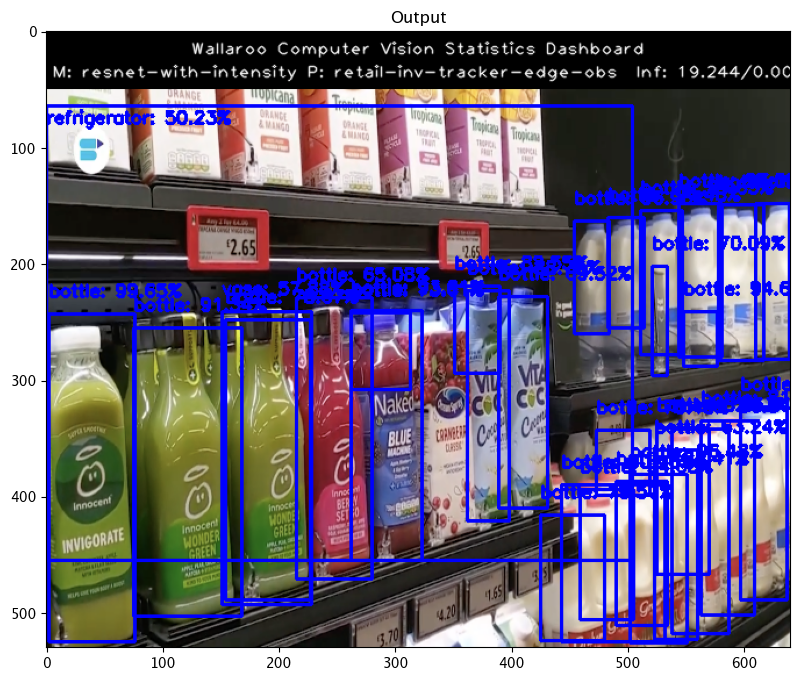

,out.avg_confidence
0,[0.3588039]


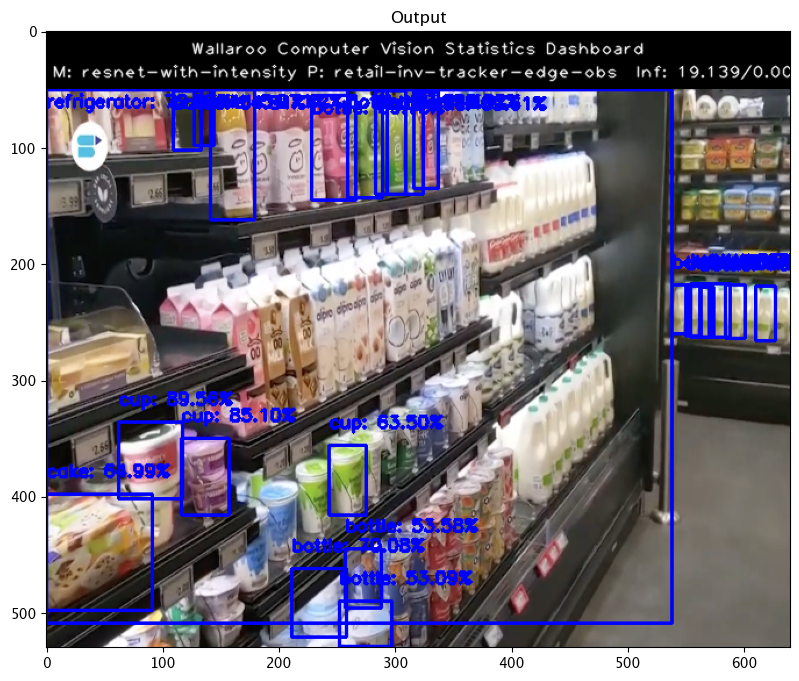

,out.avg_confidence
0,[0.2970887]


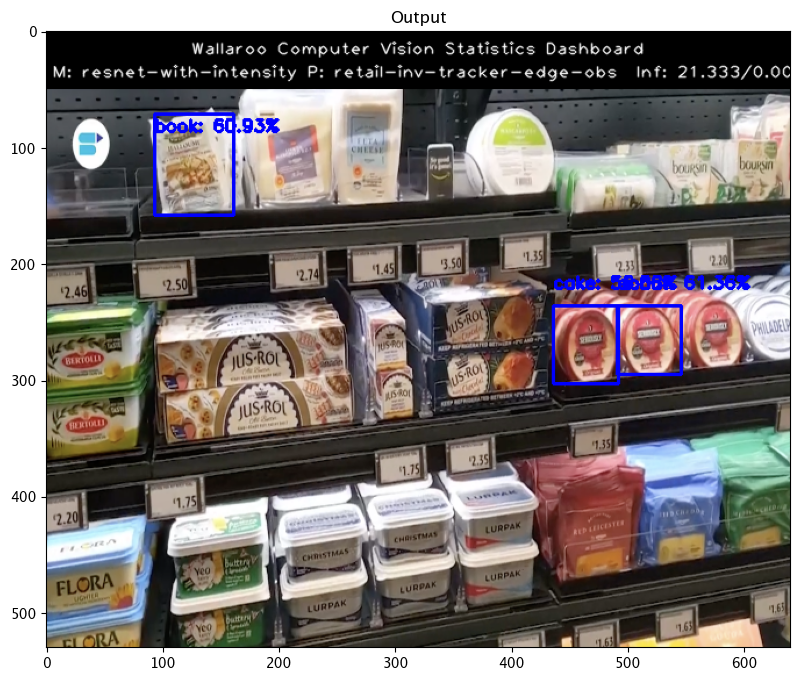

,out.avg_confidence
0,[0.1656933]


In [8]:
width, height = 640, 480

baseline_images = [
    "./data/images/input/example/dairy_bottles.png",
    "./data/images/input/example/dairy_products.png",
    "./data/images/input/example/product_cheeses.png"
]

for sample_image in baseline_images:
    dfImage, resizedImage = utils.loadImageAndConvertToDataframe(sample_image, width, height)
    startTime = time.time()
    infResults = pipeline.infer(dfImage, timeout=300)
    endTime = time.time()

    elapsed = 1.0
    results = {
        'model_name' : model_name,
        'pipeline_name' : pipeline_name,
        'width': width,
        'height': height,
        'image' : resizedImage,
        'inf-results' : infResults,
        'confidence-target' : 0.50,
        'inference-time': (endTime-startTime),
        'onnx-time' : int(elapsed) / 1e+9,
        'classes_file': "./models/coco_classes.pickle",                 
        'color': 'BLUE'
    }

    image = utils.drawDetectedObjectsFromInference(results)
    
    display(infResults.loc[:, ['out.avg_confidence']])

The Wallaroo SDK is capable of using numpy arrays in a pandas DataFrame for inference requests.  Our demonstration will focus on using API calls for inference requests, so we will flatten the numpy array and use that value for our inference inputs.  The following examples show using a baseline and blurred image for inference requests and the sample outputs.

In [9]:
pipeline.undeploy()

name,retail-inv-tracker-edge-obs
created,2024-04-16 20:52:25.348600+00:00
last_updated,2024-04-16 20:52:25.694362+00:00
deployed,False
arch,x86
accel,none
tags,
versions,"677630ba-68a0-4c32-958c-58084e24d9f9, 4fa28f09-0bc7-4622-9cbd-1706a3c94285"
steps,resnet-with-intensity
published,False
